# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
%pip install captum

  Using cached captum-0.7.0-py3-none-any.whl (1.3 MB)
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
df = pd.read_csv('hdb_price_prediction.csv')

# Training Data Set: Year 2019 and before
df_train = df[df['year'] <= 2019].copy()
# Validation Data Set: Year 2020
df_val = df[df['year'] == 2020].copy()
# Testing Data Set: Year 2021
df_test = df[df['year'] == 2021].copy()

# Dropping all Categorical Features
cat_col_names = ['month','town','flat_model_type','storey_range', 'full_address','nearest_stn','year']

df_train.drop(columns = cat_col_names, inplace=True)
df_val.drop(columns = cat_col_names, inplace=True)
df_test.drop(columns = cat_col_names, inplace=True)

print("Training Data:", df_train.shape)
print("Validation Data:", df_val.shape)
print("Testing Data:", df_test.shape) 


Training Data: (64057, 7)
Validation Data: (23313, 7)
Testing Data: (29057, 7)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159553 entries, 0 to 159552
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   month                   159553 non-null  int64  
 1   year                    159553 non-null  int64  
 2   town                    159553 non-null  object 
 3   full_address            159553 non-null  object 
 4   nearest_stn             159553 non-null  object 
 5   dist_to_nearest_stn     159553 non-null  float64
 6   dist_to_dhoby           159553 non-null  float64
 7   degree_centrality       159553 non-null  float64
 8   eigenvector_centrality  159553 non-null  float64
 9   flat_model_type         159553 non-null  object 
 10  remaining_lease_years   159553 non-null  float64
 11  floor_area_sqm          159553 non-null  float64
 12  storey_range            159553 non-null  object 
 13  resale_price            159553 non-null  float64
dtypes: float64(7), int64

In [5]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

X_val = df_val.iloc[:,:-1]
y_val = df_val.iloc[:,-1]

X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [6]:
# YOUR CODE HERE
# Taking First 1000 Samples for Testing Data (Following Discussion Board)
X_test = X_test.sample(1000)
y_test = y_test.sample(1000)

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [7]:
# YOUR CODE HERE
# Define a custom neural network class
class FeedForwardNN(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.lin1 = nn.Linear(no_features, no_hidden)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(no_hidden, no_hidden)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(no_hidden, no_hidden)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(no_hidden, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

# Define the hyperparameters
no_features = X_train.shape[1] 
no_hidden = 5                  
no_labels = 1                  
batch_size = 50
num_epochs = 200
learning_rate = 0.001

model = FeedForwardNN(no_features,no_hidden,no_labels)
model.train()

FeedForwardNN(
  (lin1): Linear(in_features=6, out_features=5, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=5, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).view(-1, 1).float()

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [9]:
import torch.optim as optim

def train(model_inp, num_epochs = num_epochs):
    
    # Define the Adam optimizer with a learning rate of 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Defining the Criterion
    criterion = nn.MSELoss(reduction='sum')
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            
            # defining loss
            loss = criterion(outputs, labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # computing gradients
            loss.backward()
            
            # accumulating running loss
            running_loss += loss.item()
            
            # updated weights based on computed gradients
            optimizer.step()
            
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [10]:
# Training Model
train(model, num_epochs)

Epoch [1]/[200] running accumulative loss across all batches: 3354470853250048.000
Epoch [21]/[200] running accumulative loss across all batches: 342543271743488.000
Epoch [41]/[200] running accumulative loss across all batches: 289534774829568.000
Epoch [61]/[200] running accumulative loss across all batches: 277164263967232.000
Epoch [81]/[200] running accumulative loss across all batches: 267822722372992.000
Epoch [101]/[200] running accumulative loss across all batches: 263135288652544.000
Epoch [121]/[200] running accumulative loss across all batches: 260051711296256.000
Epoch [141]/[200] running accumulative loss across all batches: 257812399013632.000
Epoch [161]/[200] running accumulative loss across all batches: 255875337800576.000
Epoch [181]/[200] running accumulative loss across all batches: 254147051789824.000


In [11]:
# Evaluating Model
from sklearn.metrics import mean_squared_error

model.eval()
outputs = model(X_test_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('Model Error (Mean Squared Error): ', err)

Model Error (Mean Squared Error):  227647.98


In [12]:
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)
saliency = Saliency(model)
input_x_gradient = InputXGradient(model)

ig_attr_test = ig.attribute(X_test_tensor, n_steps=50)
gs_attr_test = gs.attribute(X_test_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_tensor) 
saliency_attr_test = saliency.attribute(X_test_tensor)
input_x_gradient_attr_test = input_x_gradient.attribute(X_test_tensor)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [13]:
# Getting Features into a list
feature_names = X_test.columns.tolist()
feature_names

['dist_to_nearest_stn',
 'dist_to_dhoby',
 'degree_centrality',
 'eigenvector_centrality',
 'remaining_lease_years',
 'floor_area_sqm']

In [14]:
order_legend = ['Integrated Gradients', 'GradientShap', 'FeatureAblation', 'Saliency', 'InputXGradient', 'Weights']

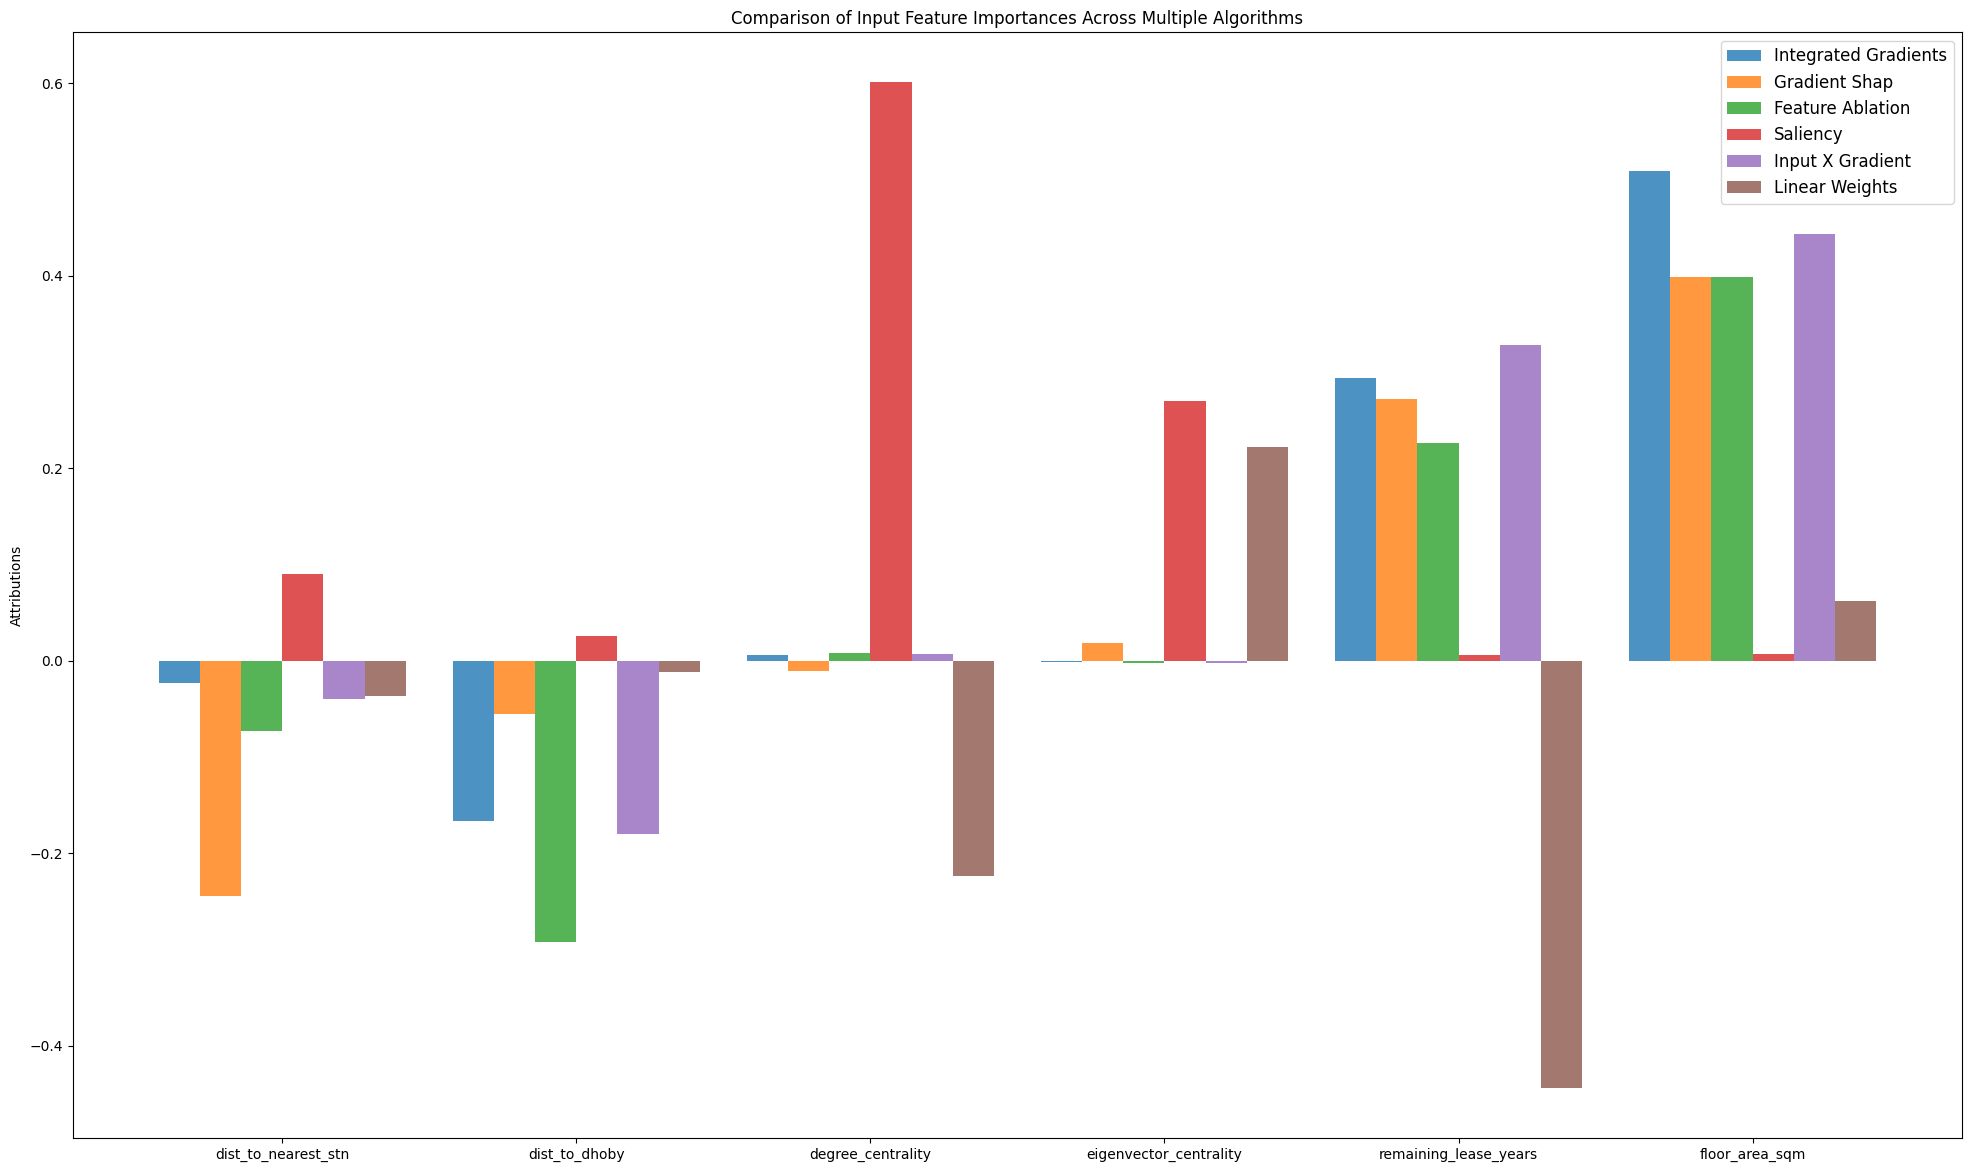

In [15]:
import matplotlib.pyplot as plt

# Prepare attribution data for visualization
x_axis_indices = np.arange(X_test.shape[1])
x_axis_labels = [feature_names[idx] for idx in x_axis_indices]

# Calculate normalized sums of attributions for different methods
def normalize_sum(attr):
    return attr.detach().numpy().sum(0) / np.linalg.norm(attr.detach().numpy().sum(0), ord=1)

methods = {
    'Integrated Gradients': normalize_sum(ig_attr_test),
    'Gradient Shap': normalize_sum(gs_attr_test),
    'Feature Ablation': normalize_sum(fa_attr_test),
    'Saliency': normalize_sum(saliency_attr_test),
    'Input X Gradient': normalize_sum(input_x_gradient_attr_test),
    'Linear Weights': model.lin1.weight[0].detach().numpy() / np.linalg.norm(model.lin1.weight[0].detach().numpy(), ord=1)
}

# Bar plot settings
width = 0.14
plt.figure(figsize=(20, 12))
ax = plt.subplot()
ax.set_title('Comparison of Input Feature Importances Across Multiple Algorithms')
ax.set_ylabel('Attributions')

# Set font sizes for better readability
FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE - 4)

# Plot the bars for each method
for i, (label, values) in enumerate(methods.items()):
    ax.bar(x_axis_indices + i * width, values, width, label=label, alpha=0.8)

# Configure the axes and legend
ax.autoscale_view()
plt.tight_layout()
ax.set_xticks(x_axis_indices + width * (len(methods) - 1) / 2)
ax.set_xticklabels(x_axis_labels)
plt.legend(loc='upper right')
plt.show()


3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [17]:
from sklearn.preprocessing import StandardScaler
# TODO: Enter your code here

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameters
no_features = X_train.shape[1] 
no_hidden = 5                  
no_labels = 1                  

scaled_model = FeedForwardNN(no_features,no_hidden,no_labels)
scaled_model.train()

FeedForwardNN(
  (lin1): Linear(in_features=6, out_features=5, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=5, out_features=5, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=5, out_features=5, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
X_train_scaled_tensor = torch.tensor(X_train_scaled).float()
X_test_scaled_tensor = torch.tensor(X_test_scaled).float()

In [19]:
train(scaled_model, num_epochs)

Epoch [1]/[200] running accumulative loss across all batches: 13859078464733184.000
Epoch [21]/[200] running accumulative loss across all batches: 13859078463619072.000
Epoch [41]/[200] running accumulative loss across all batches: 13859078466633728.000
Epoch [61]/[200] running accumulative loss across all batches: 13859078463750144.000
Epoch [81]/[200] running accumulative loss across all batches: 13859078466830336.000
Epoch [101]/[200] running accumulative loss across all batches: 13859078454378496.000
Epoch [121]/[200] running accumulative loss across all batches: 13859078458572800.000
Epoch [141]/[200] running accumulative loss across all batches: 13859078460538880.000
Epoch [161]/[200] running accumulative loss across all batches: 13859078447235072.000
Epoch [181]/[200] running accumulative loss across all batches: 13859078454640640.000


In [20]:
# YOUR CODE HERE
scaled_model.eval()
outputs = model(X_test_scaled_tensor)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test_tensor.detach().numpy()))

print('Scaled Model Error (Mean Squared Error): ', err)

Scaled Model Error (Mean Squared Error):  663455.5


In [21]:
ig = IntegratedGradients(scaled_model)
gs = GradientShap(scaled_model)
fa = FeatureAblation(scaled_model)
saliency = Saliency(scaled_model)
input_x_gradient = InputXGradient(scaled_model)

ig_attr_test = ig.attribute(X_test_scaled_tensor, n_steps=50)
gs_attr_test = gs.attribute(X_test_scaled_tensor, X_train_tensor)
fa_attr_test = fa.attribute(X_test_scaled_tensor) 
saliency_attr_test = saliency.attribute(X_test_scaled_tensor)
input_x_gradient_attr_test = input_x_gradient.attribute(X_test_scaled_tensor)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


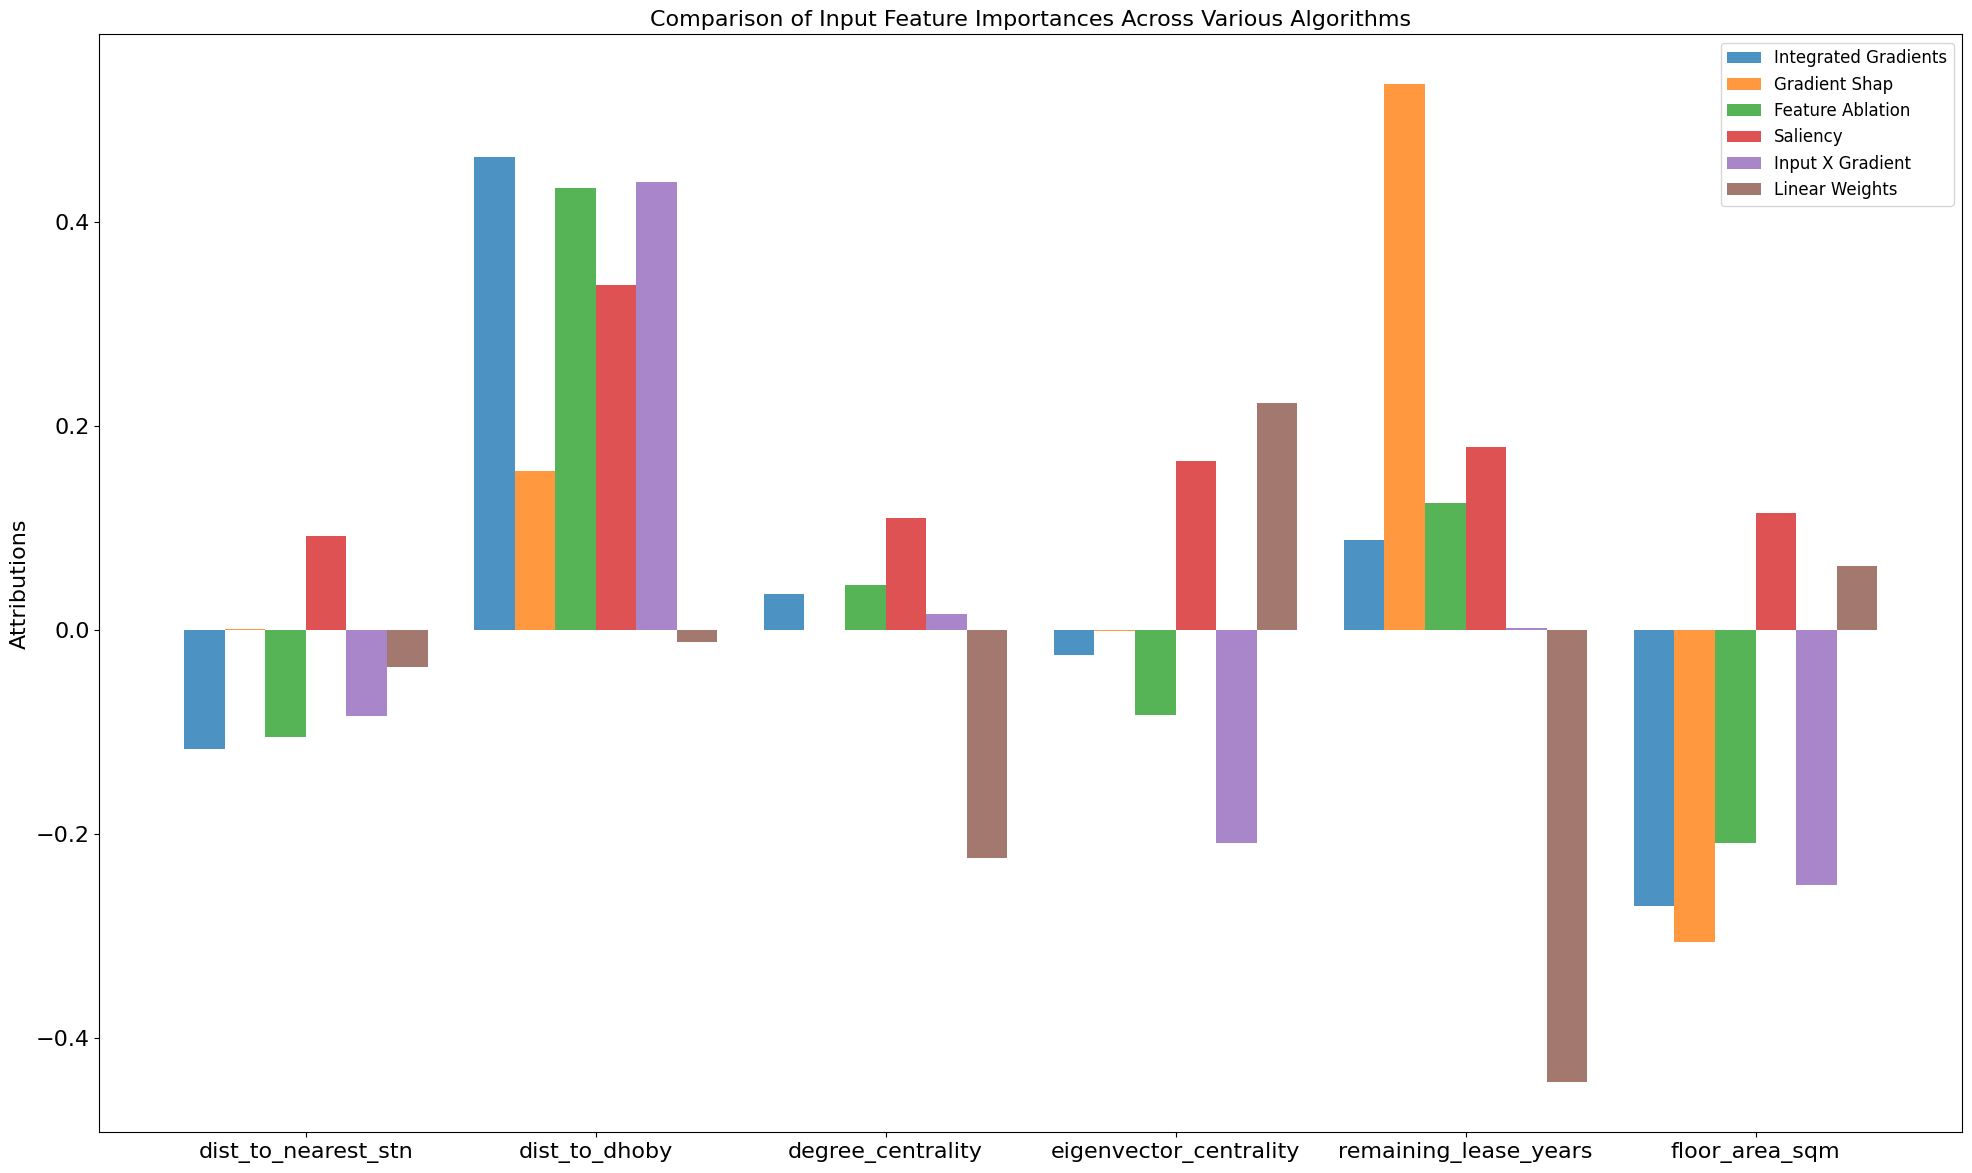

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the x-axis data and labels
num_features = X_test.shape[1]
x_axis_indices = np.arange(num_features)
x_axis_labels = [feature_names[i] for i in x_axis_indices]

# Function to calculate normalized sums of attributions
def get_normalized_sum(attr):
    total_attr = attr.detach().numpy().sum(0)
    return total_attr / np.linalg.norm(total_attr, ord=1)

# Collect normalized sums for different attribution methods
attribution_methods = {
    'Integrated Gradients': get_normalized_sum(ig_attr_test),
    'Gradient Shap': get_normalized_sum(gs_attr_test),
    'Feature Ablation': get_normalized_sum(fa_attr_test),
    'Saliency': get_normalized_sum(saliency_attr_test),
    'Input X Gradient': get_normalized_sum(input_x_gradient_attr_test),
    'Linear Weights': model.lin1.weight[0].detach().numpy() / np.linalg.norm(model.lin1.weight[0].detach().numpy(), ord=1)
}

# Set up plot
plt.figure(figsize=(20, 12))
ax = plt.subplot()
ax.set_title('Comparison of Input Feature Importances Across Various Algorithms')
ax.set_ylabel('Attributions')

# Plotting each method
width = 0.14
for i, (label, values) in enumerate(attribution_methods.items()):
    ax.bar(x_axis_indices + i * width, values, width, label=label, alpha=0.8)

# Configure plot appearance
ax.autoscale_view()
plt.tight_layout()
ax.set_xticks(x_axis_indices + width * (len(attribution_methods) - 1) / 2)
ax.set_xticklabels(x_axis_labels)
plt.legend(loc='upper right')

plt.show()


Answer to Observations with respect to GradientShap

1. The graphical output indicates that many attributes, particularly dist_to_nearest_stn, degree_centrality, and eigenvector_centrality, are close to zero. Additionally, features such as remaining_lease_years, floor_area_sqm, and dist_to_dhoby show negative deviations.
2. These findings contrast sharply with the results obtained without applying StandardScaler.

Explanation of the Phenomenon

1. The baseline choice in gradient-based attribution methods like GradientSHAP is critical, as it influences the attribution calculations by comparing model outputs at the baseline versus actual inputs.
2. With StandardScaler, feature means are adjusted to zero and standard deviations to one, centering typical inputs around zero.
3. GradientSHAP uses a zero baseline, where all feature values are set to zero.
4. Therefore, with standardized features and a zero baseline, GradientSHAP highlights features that deviate from zero, leading to both positive and negative attributions, as depicted in the graph.
5. For more insightful results, it is advisable to use a customized baseline.

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


No, Saliency and IG produced different scores: Saliency, a local method, computes the model's output gradient concerning the input features at a specific point. It gauges how a slight alteration in each feature at that point influences the model's prediction. Conversely, Integrated Gradients adopts a more comprehensive approach by computing the integral of gradients along a path from a baseline to the actual input. It assesses the cumulative impact of each feature's value change over this path.
Saliency may be more appropriate for understanding the impact of features at a single point, whereas IG can offer a more comprehensive perspective on the importance of features across a range of inputs.

5.Why did Input x Gradients give the same attribution scores as IG?


Both approaches assume that both models are roughly linear, and because the FeedForwardNN model I used here is quite linear near the input data point, the results may exhibit some similarities in attribute scores.
The greater resemblance between IG and Input x Gradients results occurs in the second graph when using StandardScaler to normalize the features. This could potentially lead to scores that are more closely aligned.